<a href="https://colab.research.google.com/github/mykon23/AI-2020/blob/project_phase_3/Project/Phase3/Phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MoneyBall Model: Feature Significance and Feature Reduction

##Define Development Set: Training and Validation

In [1]:
!wget -O Baseball.csv https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True

--2020-12-04 05:57:12--  https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv [following]
--2020-12-04 05:57:12--  https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv [following]
--2020-12-04 05:57:12--  https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 20

In [2]:
import pandas as pd

data = pd.read_csv('Baseball.csv')
data.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


In [3]:
!rm Baseball.csv
!rm *.tar

In [4]:
##Set the features of interest and the output
features = ['OBP', 'SLG', 'BA']
output = ['RS']

In [5]:
import numpy as np

work_data = data[features + output].to_numpy()
np.random.shuffle(work_data)

##Define the split point for the training set and the validation set
split_pt = int(0.25 * len(work_data))

##Set the data as two new tensors to permit normalization
TRAIN = work_data[split_pt:]
VALID = work_data[:split_pt]

XTRAIN = TRAIN[:, :-1]
XVALID = VALID[:, :-1]

YTRAIN = TRAIN[:, -1]
YVALID = VALID[:, -1]

##Normalize the training set
mean = XTRAIN.mean(axis = 0)
XTRAIN -= mean
std = XTRAIN.std(axis = 0)
XTRAIN /= std

##Normalize the validation set
XVALID -= mean
XVALID /= std

Define Evaluation Utilities

In [6]:
import matplotlib.pyplot as plt
from sklearn import metrics

class PlotUtil:
  @staticmethod
  def get_learning_curve(history):
    f, ax = plt.subplots()
    ax.plot(history.history['loss'], '-', label = 'Training', color = 'blue')
    ax.plot(history.history['val_loss'], '--', label = 'Validation', color = 'orange')
    ax.set_ylabel('Loss')
    ax.set_xlabel('epoch')
    ax.set_yscale('log')
    ax.legend()
    return (f, ax)

class RegEvalUtil:
  @staticmethod
  def get_eval_metrics(y_true, y_pred):
    return { 'mse': metrics.mean_squared_error(y_true, y_pred),
            'mae': metrics.mean_absolute_error(y_true, y_pred) }

Define Model Utilities

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class ModelUtil:
  @staticmethod
  def get_model(input):
    model = Sequential()
    model.add( Dense(18, input_dim = input, activation='elu'))
    model.add( Dense(6, activation = 'elu' ))
    model.add( Dense(3, activation = 'elu'))
    model.add( Dense(1, activation = 'linear' ))
    return model
  @staticmethod
  def get_callbacks(model_path):
    return [ ModelCheckpoint(filepath = model_path, 
                        monitor='val_loss', save_best_only = True, 
                        save_weights_only = True, verbose = 0), 
             EarlyStopping(monitor='val_loss', mode='min', 
                           patience=64, verbose=0) ]

DEFAULT_EPOCHS = 512
DEFAULT_BATCH = int(32 * 1.5)

##Feature Significance

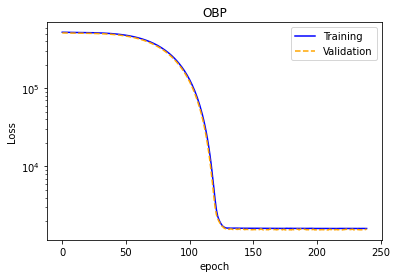

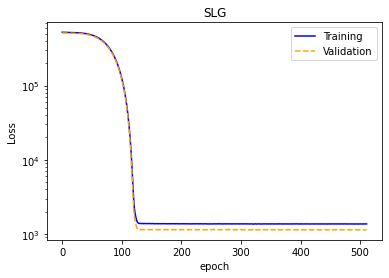

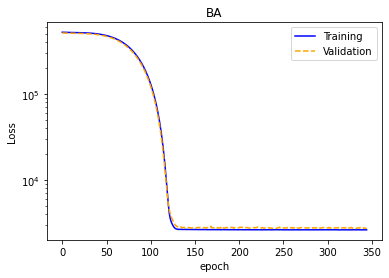

In [8]:
##Keep a dictionary to keep track of the loss
val_loss = {}

##Set the model with default weights
DEFAULT_WEIGHTS = 'default.hdf5'
model = ModelUtil.get_model(1)
model.save_weights(DEFAULT_WEIGHTS)

for i in range(len(features)):
  
  model.load_weights(DEFAULT_WEIGHTS)
  model.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'])

  ##Define the model name
  model_path = features[i] + '.hdf5'
  model_callbacks = ModelUtil.get_callbacks(model_path)

  ##Train the model
  history = model.fit( XTRAIN[:,i], YTRAIN[:],
                      validation_data = (XVALID[:,i], YVALID[:]),
                      epochs = DEFAULT_EPOCHS,
                      batch_size = DEFAULT_BATCH,
                      callbacks = model_callbacks,
                      verbose = 0)
  
  ##View the Learning Curve for the model
  figs = PlotUtil.get_learning_curve(history)
  figs[1].set_title(features[i])
  plt.savefig(features[i] + '.png')
  figs[0].show()

  ##Get the predictions from the best weights from model checkpointing
  model.load_weights(model_path)
  train_pred = model.predict(XTRAIN[:, i])
  valid_pred = model.predict(XVALID[:, i])

  eval = { 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)}
  
  val_loss[features[i]] = eval['valid']['mae']


In [9]:
##Sort features by validation loss
ranked_loss = pd.DataFrame( {'feature': val_loss.keys(), 'loss': val_loss.values()}, columns=['feature', 'loss'])
ranked_loss = ranked_loss.sort_values(by = ['loss'])
ranked_loss.to_csv('Single_Feature_Loss.csv')
ranked_loss.head(len(ranked_loss))

,feature,loss
1,SLG,26.589306
0,OBP,30.913499
2,BA,42.748085


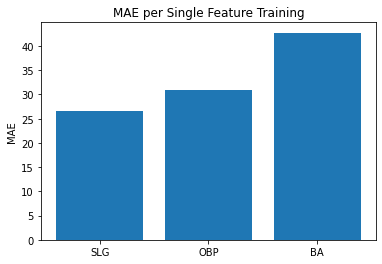

In [10]:
import matplotlib.pyplot as plt

plt.bar(ranked_loss['feature'], ranked_loss['loss'])
plt.ylabel('MAE')
plt.title('MAE per Single Feature Training')
plt.savefig('Single_Feature_Loss.png')
plt.show()

##Feature Reduction

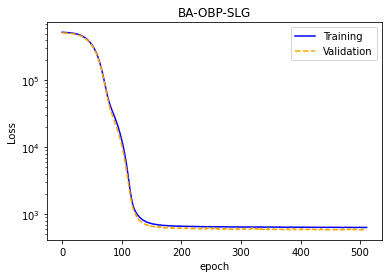

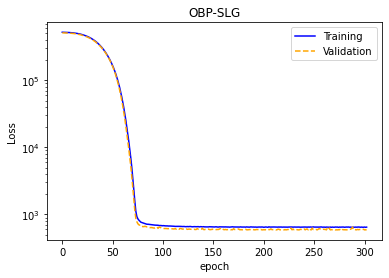

In [18]:
##Set the reduce features list to contain the indices for each features
feature_red = [ features.index(u) for u in ranked_loss['feature']]

##Keep a dictionary to keep track of the loss
val_loss_red = {}

##Train reduced model for features greater than one
while len(feature_red) > 1:

  ##Set the updated np array
  x_train_red = XTRAIN[:, feature_red]
  x_valid_red = VALID[:, feature_red]
  
  model = ModelUtil.get_model(len(feature_red))
  model.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'])

  ##Set the indentifier
  key = '-'.join(sorted([features[i] for i in feature_red]))
  model_path = key + '.hdf5'
  model_callbacks = ModelUtil.get_callbacks(model_path)

  ##Train the model
  history = model.fit( x_train_red, YTRAIN[:],
                      validation_data = (x_valid_red, YVALID[:]),
                      epochs = DEFAULT_EPOCHS,
                      batch_size = DEFAULT_BATCH,
                      callbacks = model_callbacks,
                      verbose = 0)
  
  ##View the Learning Curve for the model
  figs = PlotUtil.get_learning_curve(history)
  figs[1].set_title(key)
  plt.savefig(key + '.png')
  figs[0].show()

  ##Get the predictions from the best weights from model checkpointing
  model.load_weights(model_path)
  train_pred = model.predict(x_train_red)
  valid_pred = model.predict(x_valid_red)

  eval = { 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)}
  
  val_loss_red[key] = eval['valid']['mae']

  ##Remove the least import feature
  feature_red.pop()


In [19]:
##Sort features by validation loss
ranked_loss_red = pd.DataFrame( {'feature': val_loss_red.keys(), 'loss': val_loss_red.values()}, columns=['feature', 'loss'])
ranked_loss_red.to_csv('Feature_Reduction_Loss.csv')
ranked_loss_red.head(len(ranked_loss_red))

,feature,loss
0,BA-OBP-SLG,18.976946
1,OBP-SLG,18.907755


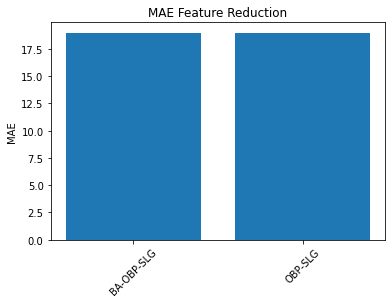

In [20]:
import matplotlib.pyplot as plt

plt.bar(ranked_loss_red['feature'], ranked_loss_red['loss'])
plt.xticks(rotation = 45)
plt.ylabel('MAE')
plt.title('MAE Feature Reduction')
plt.savefig('Feature_Reduction_Loss.png')
plt.show()

##Collect Information for Report

In [14]:
##Create directory to contain all the desired contents
!if [[ ! -e proj_dir ]]; then mkdir proj_dir; fi

In [15]:
!mv *.csv proj_dir/
!mv *.png proj_dir/

In [16]:
!tar -cvf phase3.tar proj_dir/

proj_dir/
proj_dir/BA.png
proj_dir/BA-OBP-SLG.png
proj_dir/Single_Feature_Loss.png
proj_dir/Feature_Reduction_Loss.png
proj_dir/Single_Feature_Loss.csv
proj_dir/OBP-SLG.png
proj_dir/Feature_Reduction_Loss.csv
proj_dir/SLG.png
proj_dir/OBP.png


In [21]:
from google.colab import files

files.download('phase3.tar')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>